# Landuse machine learning model -test-

This notebook integrates the first steps towards the development of a machine learning model for urban landuse prediction.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import aup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from keras import utils                                   # tools for creating one-hot encoding
from keras.models import Sequential                       # Type of model we wish to use
from keras.layers import Dense, Dropout, Activation  
from sklearn.preprocessing import LabelEncoder
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras import utils  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
# from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,confusion_matrix

2025-04-22 19:26:01.217029: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 19:26:01.223891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745371561.231634  113046 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745371561.233877  113046 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745371561.239938  113046 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data for model training

In [2]:
gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/tess_kde_env.geojson')
print(gdf.shape)
gdf.head(2)

(26735, 31)


,fid,UNUSO,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_pct,pobtot,cultural_recreativo,...,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria,temperature_mean_diff,ndvi_mean,ndmi_diff,geometry
0,263,Baldio,1492.077966,75GRMHVV+R4XJ,141200001116A008,82.3788,190471.939851,0.007834,277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.448344,0.365584,0.075350,"POLYGON ((665861.85 2289152.881, 665861.743 22..."
1,264,Habitacional,192.276653,75GRMHVR+PR5P,141200001116A008,45.6562,190471.939851,0.001009,277,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.326428,0.292687,0.066635,"POLYGON ((665814.876 2289122.473, 665814.781 2..."


In [3]:
gdf.columns

Index(['fid', 'UNUSO', 'area_m2', 'full_plus_code', 'CVEGEO', 'bld_area_m2',
       'block_area_m2', 'pred_area_pct', 'pobtot', 'cultural_recreativo',
       'servicios', 'comercio', 'salud', 'educacion', 'gobierno', 'industria',
       'area_m2_tot', 'habitacional', 'uso_tot', 'pct_habitacional',
       'pct_cultural_recreativo', 'pct_servicios', 'pct_comercio', 'pct_salud',
       'pct_educacion', 'pct_gobierno', 'pct_industria',
       'temperature_mean_diff', 'ndvi_mean', 'ndmi_diff', 'geometry'],
      dtype='object')

## Machine learning model

### Data preprocessing

Divide X and Y data

In [4]:
X = gdf[['area_m2','bld_area_m2','pobtot','uso_tot',
                 'pct_habitacional','pct_servicios','pct_comercio',
                 'pct_salud','pct_educacion','pct_gobierno','pct_industria',
        'block_area_m2','pred_area_pct','temperature_mean_diff',
        'ndvi_mean','ndmi_diff']].to_numpy()
Y = gdf[['UNUSO']].to_numpy()
Y = np.reshape(Y, shape=(Y.shape[0],))

Standarize and encode data

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Divide training, validation and testing data

In [6]:
X_model, X_test, y_model, y_test = (train_test_split(X_scaled, encoded_Y, test_size=0.2, random_state=0))
X_train, X_val, y_train, y_val = (train_test_split(X_model, y_model, test_size=0.2, random_state=0))

Y data to categorical

In [7]:
# encode class values as integers
num_classes = len(gdf.UNUSO.unique())

# convert integers to dummy variables (i.e. one hot encoded)
y_train = utils.to_categorical(y_train, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_val = utils.to_categorical(y_val, num_classes)

# convert integers to dummy variables (i.e. one hot encoded)
y_test = utils.to_categorical(y_test, num_classes)

### Model construction -- Classification Neural network

Model parameters

In [8]:
input_shape = (X_train.shape[1],)

In [9]:
### Construct Keras model

# A sequential model is a linear stack of layers
model = Sequential()

# First layer: fully-connected with relu activation
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second layer: fully-connected with relu activation
model.add(Dense(64))   # Input shape is determined automatically from previous layer
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Third layer: 10 nodes, one for each class, and softmax activation
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary
print(model.summary())
    

/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745371564.846639  113046 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4665 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11)             │           715 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,963 (23.29 KB)

 Trainable params: 5,963 (23.29 KB)

 Non-trainable params: 0 (0.00 B)

None


Model training

In [10]:
### Train the model
history = model.fit(X_train,
                    y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_val, y_val)
                   )

Epoch 1/200


I0000 00:00:1745371565.499935  113193 service.cc:152] XLA service 0x7f731c008640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745371565.499950  113193 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-04-22 19:26:05.512194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745371565.572975  113193 cuda_dnn.cc:529] Loaded cuDNN version 90300


296/535 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - acc: 0.6995 - loss: 1.2811

I0000 00:00:1745371566.199952  113193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - acc: 0.7232 - loss: 1.1330 - val_acc: 0.7803 - val_loss: 0.7304
Epoch 2/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - acc: 0.7775 - loss: 0.7666 - val_acc: 0.7903 - val_loss: 0.7002
Epoch 3/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - acc: 0.7839 - loss: 0.7234 - val_acc: 0.7941 - val_loss: 0.6870
Epoch 4/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - acc: 0.7865 - loss: 0.7075 - val_acc: 0.7901 - val_loss: 0.6842
Epoch 5/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - acc: 0.7861 - loss: 0.6980 - val_acc: 0.7929 - val_loss: 0.6751
Epoch 6/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - acc: 0.7926 - loss: 0.6948 - val_acc: 0.7971 - val_loss: 0.6713
Epoch 7/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - acc: 0.7887 - loss: 0.6901 - val_acc: 0.7976 - val_loss: 0.6656
Epoch 8/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - acc: 0.7886 - loss: 0.6819 - val_acc: 0.7976 - val_loss: 0.6572
Epoch 9/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 0s 65

Evaluate model

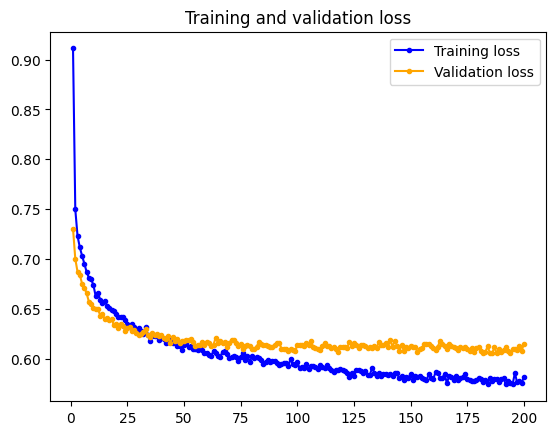

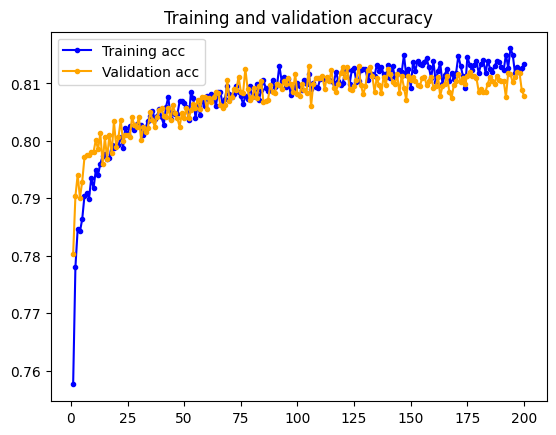

In [11]:
### Plot training and validation accuracy and loss over time

# Extract accuracy and loss values (in list form) from the history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [12]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
y_pred = model.predict(X_val)
print("Validation output shape:", y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val_trans = np.argmax(y_val, axis=1)
y_pred_trans = np.argmax(y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val_trans[:50])
print("Predicted validation labels:\t", y_pred_trans[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val_trans, y_pred_trans)
cm = np.transpose(cm)

labels = range(len(gdf['UNUSO'].unique()))

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
  print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))
    

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation output shape: (4278, 11)
Actual validation labels:	 [4 4 4 4 4 4 4 4 0 8 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 2 8 4 4
 4 0 4 4 4 4 4 1 4 4 4 4 4]
Predicted validation labels:	 [4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 8 4 4
 4 0 4 4 4 4 4 1 4 4 4 4 4]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)    (5)    (6)    (7)    (8)    (9)    (10)  
           0 (0):  [   238      2      0     10     47      4      2      0     12      1      0]
           1 (1):  [     2     33      0      0      2      0      0      0      3      0      0]
           2 (2):  [     1      0     15      1      1      0      0      0      1      0      0]
           3 (3):  [     3      1      7     27      6      0      0      0      1      0      1]
           4 (4):  [   371     41     41     82   3077     16      2     13    104      6      2]
           5 (5):  [     2      1      1      0 

Predict landuse for every element

In [13]:
y_hat = model.predict(X_scaled)

836/836 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step


2025-04-22 19:27:25.836366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads



Assign data to polygons

In [14]:
gdf['pred'] = y_hat.argmax(axis=1)

### Save output

In [15]:
gdf.to_file('../../data/processed/prediccion_uso_suelo/tess_pred_test.geojson')